### Clinical Drift Detection

In [ ]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
from cyclops.utils.file import load_pickle, save_pickle
from drift_detection.drift_detector.clinical_applicator import ClinicalShiftApplicator
from drift_detection.drift_detector.detector import Detector
from drift_detection.drift_detector.experimenter import Experimenter
from drift_detection.drift_detector.plotter import plot_drift_samples_pval
from drift_detection.drift_detector.reductor import Reductor
from drift_detection.drift_detector.tester import DCTester, TSTester
from drift_detection.gemini.utils import import_dataset_hospital
from drift_detection.gemini.constants import DIAGNOSIS_DICT, ACADEMIC, COMMUNITY, HOSPITALS
from drift_detection.gemini.utils import get_use_case_params, impute, get_source_target
from models.temporal.utils import (
    get_device,
)
from drift_detection.drift_detector.plotter import plot_drift_samples_pval, errorfill, linestyles, colors, markers, colorscale, brightness

## Config Parameters ##

In [2]:
PATH = "/mnt/nfs/project/delirium/drift_exp/OCT-18-2022/" 
DATASET = "gemini"
USE_CASE = "mortality"
ID = SHIFT = input("Select data split: ")
DIAGNOSIS_TRAJECTORY = input("Select diagnosis trajectory to filter on: ") 
HOSPITAL = input("Select hospital to filter on: ") 

splice_map = {
    "hospital_id": HOSPITALS
}

if DIAGNOSIS_TRAJECTORY != "all":
    diagnosis_trajectory = '_'.join(DIAGNOSIS_DICT[DIAGNOSIS_TRAJECTORY])
    ID = ID +"_"+ diagnosis_trajectory
    splice_map["diagnosis_trajectory"] = [diagnosis_trajectory]
    
if HOSPITAL != "all":
    ID = HOSPITAL + "_" + ID 
    splice_map["hospital_id"] = [HOSPITAL]
    
use_case_params = get_use_case_params(DATASET, USE_CASE)    
MODEL_PATH = os.path.join(
    PATH,
    DATASET,
    USE_CASE,
    "saved_models",
    ID + "_reweight_positive_lstm.pt"
)

MODEL_PATH = os.path.join(
    PATH,
    DATASET,
    USE_CASE,
    "saved_models",
    "random_reweight_positive_lstm_1.pt"
)

if SHIFT == "simulated_deployment":
    exp_params = {
        "source": [datetime.date(2015, 1, 1), datetime.date(2019, 1, 1)],
        "target": [datetime.date(2019, 1, 1), datetime.date(2020, 8, 1)],
        "shift_type": "source_target",
    }

if SHIFT == "covid":
    exp_params = {
        "source": [datetime.date(2019, 1, 1), datetime.date(2020, 2, 1)],
        "target": [datetime.date(2020, 3, 1), datetime.date(2020, 8, 1)],
        "shift_type": "time",
    }

if SHIFT == "seasonal_summer":
    exp_params = {
        "source": [1, 2, 3, 4, 5, 10, 11, 12],
        "target": [6, 7, 8, 9],
        "shift_type": "month",
    }

if SHIFT == "seasonal_winter":
    exp_params = {
        "source": [3, 4, 5, 6, 7, 8, 9, 10],
        "target": [11, 12, 1, 2],
        "shift_type": "month",
    }

if SHIFT == "hosp_type_academic":
    exp_params = {
        "source": ACADEMIC,
        "target": COMMUNITY,
        "shift_type": "hospital_type",
    }

if SHIFT == "hosp_type_community":
    exp_params = {
        "source": COMMUNITY,
        "target": ACADEMIC,
        "shift_type": "hospital_type",
    }

Select data split:  day
Select diagnosis trajectory to filter on:  all
Select hospital to filter on:  all


## Query Data ##

In [ ]:
use_case_params = get_use_case_params(DATASET, USE_CASE)

(X_tr_final, y_tr), (X_val_final, y_val), (X_t_final, y_t) = import_dataset_hospital(
    use_case_params.TAB_VEC_COMB, ID, train_frac=0.8, shuffle=True,
)

## Reductor

In [ ]:
DR_TECHNIQUE = input("Select dimensionality reduction technique: ")

reductor = Reductor(
    dr_method=DR_TECHNIQUE,
    model_path=MODEL_PATH,
    n_features=X_tr_final.shape[2],
    var_ret=0.8,
)

## Tester

In [ ]:
TESTER_METHOD = input("Select test method: ")
tstesters=["lk", "lsdd", "mmd", "tabular", "ctx_mmd","chi2", "fet", "ks" ]
CONTEXT_TYPE=None
REPRESENTATION=None
dctesters =["spot_the_diff", "classifier", "classifier_uncertainty"]

if TESTER_METHOD in tstesters:
    tester = TSTester(
        tester_method=TESTER_METHOD,
    )
    if TESTER_METHOD == "ctx_mmd":
        CONTEXT_TYPE = input("Select context type: ")
        
elif TESTER_METHOD in dctesters:
    MODEL_METHOD = input("Select model method: ")
    tester = DCTester(
        tester_method=TESTER_METHOD,
        model_method=MODEL_METHOD,
    )
        
    if TESTER_METHOD == "lk":
        REPRESENTATION = input("Select learned kernel representation: ")
  

## Detector

In [ ]:
detector = Detector(
    reductor = reductor,
    tester = tester,
    p_val_threshold = 0.05
    
)
detector.fit(
    X_tr_final,
    backend="pytorch",
    device = "cuda",
    model_path = MODEL_PATH,
    model_name = MODEL_METHOD,
    batch_size=32,
    verbose=0,
    alternative="greater",
    input_dim=X_tr_final.shape[2],
)

## ClinicalShiftApplicator

In [ ]:
tab_features = load_pickle(use_case_params.TAB_FEATURES_FILE)

#clinicalshiftapplicator = ClinicalShiftApplicator(
#    shift_type = exp_params['shift_type'],
#    admin_data = tab_features.data
    
#) 

experimenter = Experimenter(
    detector = detector,
    experiment_type = "sensitivity_test",
#    shiftapplicator = clinicalshiftapplicator,
)

## Experimenter

In [ ]:
val_drift_results = experimenter.sensitivity_test(
    X_val_final,
    
)
test_drift_results = experimenter.sensitivity_test(
    X_t_final,
)
shift_results = {
    'baseline': val_drift_results,
    'experiment': test_drift_results
}

## Plot drift results

In [ ]:
shift_results = {
    'baseline': val_drift_results,
    'experiment': test_drift_results
}

plot_drift_samples_pval(shift_results, 0.05)

In [103]:
results_path=os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join([ID, DR_TECHNIQUE,TESTER_METHOD])+'.pkl')
results_path

'/mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/seasonal_winter_BBSDs_trained_LSTM_ks.pkl'

In [104]:
save_pickle(shift_results, results_path)
shift_results

{'baseline': {'samples': [10, 20, 50, 100, 200, 500, 1000],
  'mean_p_vals': array([0.14789266, 0.27177774, 0.33275323, 0.3530289 , 0.22298896,
         0.1611951 , 0.18293921]),
  'std_p_vals': array([0.13274826, 0.17278761, 0.1464999 , 0.2731475 , 0.25145931,
         0.17073917, 0.17183275]),
  'mean_dist': array([0.32375997, 0.17964524, 0.10538189, 0.07737027, 0.07428567,
         0.04932399, 0.03627247]),
  'std_dist': array([0.08246634, 0.04180845, 0.02484803, 0.03164347, 0.02894858,
         0.01508333, 0.01455978])},
 'experiment': {'samples': [10, 20, 50, 100, 200, 500, 1000],
  'mean_p_vals': array([0.19281419, 0.33420186, 0.42404534, 0.25915726, 0.34963704,
         0.41067748, 0.27548564]),
  'std_p_vals': array([0.23445848, 0.28525068, 0.26606482, 0.2317227 , 0.2183722 ,
         0.24408114, 0.20111195]),
  'mean_dist': array([0.32179949, 0.20361979, 0.09668901, 0.08781222, 0.05324877,
         0.03180417, 0.02901537]),
  'std_dist': array([0.11609305, 0.11897689, 0.040857

## Plot all data shift experiments

In [3]:
PATH = "/mnt/nfs/project/delirium/drift_exp/OCT-18-2022/" 
DATASET = "gemini"
USE_CASE ="mortality"
DR_TECHNIQUE="BBSDs_trained_LSTM"
TESTER_METHOD="ks"

def plot_drift_samples_pval(results, p_val_threshold,line=0, mark=0, bright=1):
    
    """Plot drift experiement p-values."""
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111)
    for shift_iter, shift in enumerate(results.keys()):
        errorfill(
            results[shift]["samples"],
            -np.log10(results[shift]["mean_p_vals"]),
            results[shift]["std_p_vals"],
            fmt=linestyles[line] + markers[mark],
            color=colorscale(colors[shift_iter], brightness[bright]),
            label=shift,
            ax=ax,
        )
    plt.xlabel("Number of samples from test")
    plt.ylabel("-log($p$-value)")
    plt.axhline(y=-np.log10(p_val_threshold), color="k")
    plt.legend()
    plt.show()
    

2023-03-23 17:17:08,961 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/nursing_home_BBSDs_trained_LSTM_ks_random.pkl
2023-03-23 17:17:08,973 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/acute_care_BBSDs_trained_LSTM_ks_random.pkl
2023-03-23 17:17:08,983 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/not_nursing_home_BBSDs_trained_LSTM_ks_random.pkl
2023-03-23 17:17:08,987 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/not_acute_care_BBSDs_trained_LSTM_ks_random.pkl


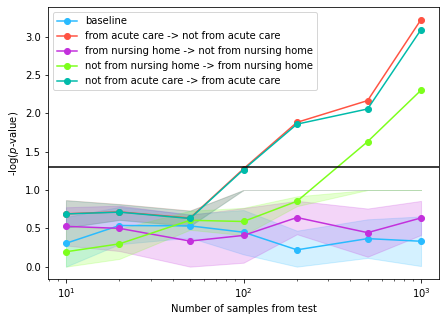

In [5]:
partone = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["nursing_home", DR_TECHNIQUE,TESTER_METHOD,"random"])+'.pkl'))
partone['from nursing home -> not from nursing home'] = partone['experiment']
parttwo = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["acute_care", DR_TECHNIQUE,TESTER_METHOD,"random"])+'.pkl'))
parttwo['from acute care -> not from acute care'] = parttwo['experiment']
parttwo.update(partone)
partthree = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["not_nursing_home", DR_TECHNIQUE,TESTER_METHOD,"random"])+'.pkl'))
partthree['not from nursing home -> from nursing home'] = partthree['experiment']
parttwo.update(partthree)
partfour = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["not_acute_care", DR_TECHNIQUE,TESTER_METHOD,"random"])+'.pkl'))
partfour['not from acute care -> from acute care'] = partfour['experiment']
parttwo.update(partfour)
parttwo.pop('experiment', None)
plot_drift_samples_pval(parttwo, 0.05)

2023-03-23 16:25:35,230 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/adult_45_64_BBSDs_trained_LSTM_ks.pkl
2023-03-23 16:25:35,233 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/geriatric_BBSDs_trained_LSTM_ks.pkl
2023-03-23 16:25:35,236 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/adult_30_44_BBSDs_trained_LSTM_ks.pkl
2023-03-23 16:25:35,239 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/adult_18_29_BBSDs_trained_LSTM_ks.pkl


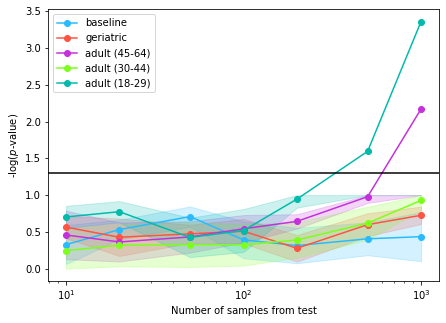

In [4]:
partone = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["adult_45_64", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
partone['adult (45-64)'] = partone['experiment']
parttwo = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["geriatric", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
parttwo['geriatric'] = parttwo['experiment']
parttwo.update(partone)
partthree = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["adult_30_44", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
partthree['adult (30-44)'] = partthree['experiment']
parttwo.update(partthree)
partfour = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["adult_18_29", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
partfour['adult (18-29)'] = partfour['experiment']
parttwo.update(partfour)

parttwo.pop('experiment', None)
plot_drift_samples_pval(parttwo, 0.05)

2023-03-23 16:15:48,956 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/male_BBSDs_trained_LSTM_ks.pkl
2023-03-23 16:15:48,958 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/female_BBSDs_trained_LSTM_ks.pkl


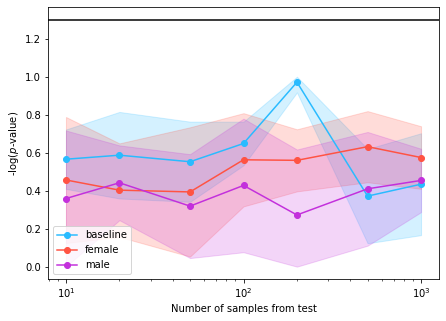

In [5]:
partone = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["male", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
partone['male'] = partone['experiment']
parttwo = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["female", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
parttwo['female'] = parttwo['experiment']
parttwo.update(partone)
parttwo.pop('experiment', None)
plot_drift_samples_pval(parttwo, 0.05)

2023-03-23 14:21:50,177 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/weekend_BBSDs_trained_LSTM_ks.pkl
2023-03-23 14:21:50,181 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/weekday_BBSDs_trained_LSTM_ks.pkl
2023-03-23 14:21:50,186 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/day_BBSDs_trained_LSTM_ks.pkl
2023-03-23 14:21:50,191 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/night_BBSDs_trained_LSTM_ks.pkl


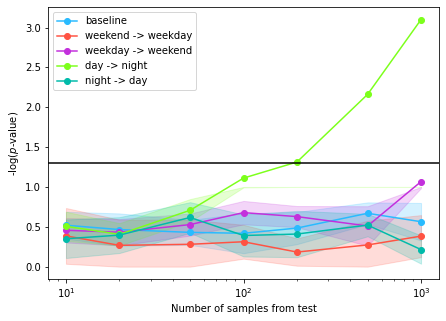

In [7]:
partone = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["weekend", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
partone['weekday -> weekend'] = partone['experiment']
parttwo = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["weekday", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
parttwo['weekend -> weekday'] = parttwo['experiment']
parttwo.update(partone)
partthree = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["day", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
partthree['day -> night'] = partthree['experiment']
parttwo.update(partthree)
partfour = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["night", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
partfour['night -> day'] = partfour['experiment']
parttwo.update(partfour)
parttwo.pop('experiment', None)
plot_drift_samples_pval(parttwo, 0.05)

2023-03-23 14:22:11,307 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/seasonal_summer_BBSDs_trained_LSTM_ks.pkl
2023-03-23 14:22:11,313 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/seasonal_winter_BBSDs_trained_LSTM_ks.pkl


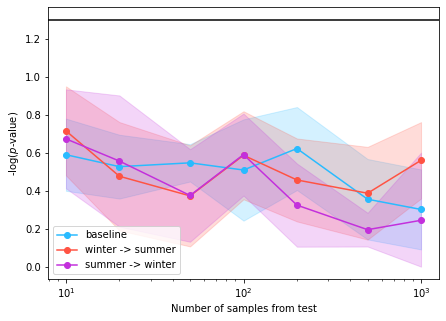

In [8]:
partone = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["seasonal_summer", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
partone['summer -> winter'] = partone['experiment']
parttwo = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["seasonal_winter", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
parttwo['winter -> summer'] = parttwo['experiment']
parttwo.update(partone)
parttwo.pop('experiment', None)
plot_drift_samples_pval(parttwo, 0.05)

2023-03-23 14:22:22,099 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/hosp_type_academic_BBSDs_trained_LSTM_ks.pkl
2023-03-23 14:22:22,104 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/hosp_type_community_BBSDs_trained_LSTM_ks.pkl


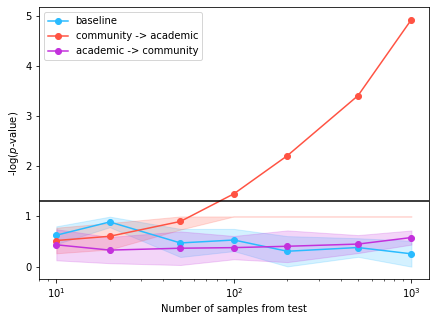

In [9]:
partone = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["hosp_type_academic", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
partone['academic -> community'] = partone['experiment']
parttwo = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["hosp_type_community", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
parttwo['community -> academic'] = parttwo['experiment']
parttwo.update(partone)
parttwo.pop('experiment', None)
plot_drift_samples_pval(parttwo, 0.05)